# Visualizing details of the goal misgeneralization nets
Let's understand lots of details about [the goal misgeneralization paper](https://arxiv.org/abs/2105.14111). In particular, we'll be looking at the cheese-maze task from the goal misgeneralization task, for which cheese was spawned in the 5x5 top-right corner of the maze. 

Key conclusions:
1. Convolutional layers limit speed of information propagation (_locality_). More precisely, ignoring the effect of `maxpool2D` layers, any portions of the state separated by `n` pixels take at least `n/2` convolutional layers to interact.
2. In the maximal maze size of 64 x 64, there is at most **two** steps of computation involving information from e.g. opposite corners of the maze. 

In [42]:
# %% Don't have to restart kernel and reimport each time you modify a dependency
%reload_ext autoreload
%autoreload 2

# %%
# Imports
from typing import List, Tuple, Dict, Union, Optional, Callable
import re 

import numpy as np
import pandas as pd
import torch as t
import plotly.express as px
import plotly as py
import plotly.graph_objects as go
from tqdm import tqdm
from einops import rearrange
from IPython.display import Video, display, clear_output, IFrame
from ipywidgets import *
import itertools
from moviepy.video.io.ImageSequenceClip import ImageSequenceClip
import matplotlib.pyplot as plt

import circrl.module_hook as cmh
import procgen_tools.models as models
from experiments.patch_utils import *

from procgen import ProcgenGym3Env

RAND_REGION = 5
NUM_ACTIONS = 15
try:
    get_ipython()
    in_jupyter = True
except NameError:
    in_jupyter = False
path_prefix = '../' if in_jupyter else ''

# %%
# Load model
model_path = path_prefix + f'trained_models/maze_I/model_rand_region_{RAND_REGION}.pth'
policy = models.load_policy(model_path, NUM_ACTIONS, t.device('cpu'))
hook = cmh.ModuleHook(policy)

In [ ]:
# There's a bug in hiddenlayer atm
# import hiddenlayer as hl
# model = models.InterpretableImpalaModel(in_channels=3)
# hl.build_graph(model, t.zeros((1,3, 64, 64), dtype=t.float32))

from torchviz import make_dot
model = models.InterpretableImpalaModel(in_channels=3)
yhat = model(t.zeros((1,3, 64, 64), dtype=t.float32))
dot = make_dot(yhat, params=dict(list(model.named_parameters()))).render('model_graph', format='png') 

dot = make_dot(yhat, params=dict(list(model.named_parameters())))
# Load and imshow the png
from IPython.display import Image
display(Image('model_graph.png'))

# Delete the files 
import os
os.remove('model_graph.png')
os.remove('model_graph')

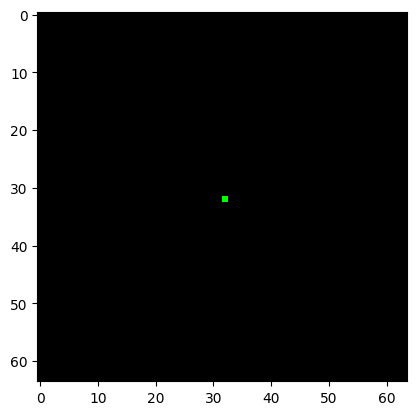

In [43]:
def dummy_obs_pair(color: str, location: Tuple[int, int]=(32,32)):
    """ Returns a mostly-black image containing a red/green/blue pixel in the center. Returns shape (2, 3, 64, 64). """
    
    assert color in ['R', 'G', 'B'], f'Color must be one of R, G, B, not {color}'
    assert len(location) == 2, 'Location must be a tuple of length 2'
    assert all(0 <= col < 64 for col in location), 'Location must be in [0, 64)'

    channel = {'R': 0, 'G': 1, 'B': 2}[color]
    obs = np.zeros((2, 3, 64, 64), dtype=np.float32)
    obs[0, channel, location[0], location[1]] = 1 # Have one pixel in the middle, in the given channel
    return obs
    
# Let's load a dummy observation with only one nonzero value
plt.imshow(dummy_obs_pair("G")[0].transpose(1,2,0))

In [44]:
# Get the available labels
hook.probe_with_input(dummy_obs_pair('R'))
labels = list(hook.values_by_label.keys())[:-1] # Skip the "_out" layer
print(labels)

['embedder.block1.conv_in0', 'embedder.block1.conv_out', 'embedder.block1.maxpool_out', 'embedder.block1.res1.relu1_out', 'embedder.block1.res1.conv1_out', 'embedder.block1.res1.relu2_out', 'embedder.block1.res1.conv2_out', 'embedder.block1.res1.resadd_out', 'embedder.block1.res2.relu1_out', 'embedder.block1.res2.conv1_out', 'embedder.block1.res2.relu2_out', 'embedder.block1.res2.conv2_out', 'embedder.block1.res2.resadd_out', 'embedder.block2.conv_out', 'embedder.block2.maxpool_out', 'embedder.block2.res1.relu1_out', 'embedder.block2.res1.conv1_out', 'embedder.block2.res1.relu2_out', 'embedder.block2.res1.conv2_out', 'embedder.block2.res1.resadd_out', 'embedder.block2.res2.relu1_out', 'embedder.block2.res2.conv1_out', 'embedder.block2.res2.relu2_out', 'embedder.block2.res2.conv2_out', 'embedder.block2.res2.resadd_out', 'embedder.block3.conv_out', 'embedder.block3.maxpool_out', 'embedder.block3.res1.relu1_out', 'embedder.block3.res1.conv1_out', 'embedder.block3.res1.relu2_out', 'embedde

/Users/pninagrietzer/opt/anaconda3/lib/python3.9/site-packages/circrl/module_hook.py:219: UserWarning:

Function probe_with_input is deprecated due to
        a confusing name and has been replaced with run_with_input.



In [45]:
# Let's visualize the activations at each layer using plotly, using an interactive interface that lets us slide the R/G/B pixel around
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px

def get_activations(label: str, obs: np.ndarray):
    hook.probe_with_input(obs) # Run the model with the given obs
    return hook.get_value_by_label(label) # Shape is (b, c, h, w) at conv layers, (b, activations) at linear layers

def activation_diff(label: str, obs: np.ndarray):
    assert obs.shape[0] == 2 # Must be a pair of observations
    
    activations = get_activations(label, obs)
    return activations[0] - activations[1] # Subtract in order to cancel out bias terms which don't behave differently in the presence of the differing inputs 

def plot_activations(label: str, channel: int, activations: np.ndarray, fig: go.FigureWidget):
    """ Plot the activations of a given channel at a given layer, given a single (non-batched) activation tensor. """
    if len(activations.shape) == 1: # Linear layer
        # Unsqueeze the np.ndarray
        activations = np.expand_dims(activations, axis=(0,1))
        # If there's only a single channel, display a 1D Heatmap, with a single rowvalue and the activation indices as the col values TODO remove columns, display action labels
        new_data = go.Heatmap(y=activations[channel], x=np.arange(activations.shape[2]))
        if label == 'fc_policy_out':
            # Transform each index into the corresponding action label, according to maze.py 
            new_data['x'] = [models.MAZE_ACTION_INDICES[i].title() for i in range(NUM_ACTIONS)] # TODO convert to human readable
    else: 
        assert channel < activations.shape[0], "Channel doesn't exist at this layer"
        new_data = go.Heatmap(z=activations[channel])
    
    fig.update_xaxes(side="top") # Set the x ticks to the top
    fig.update_yaxes(autorange="reversed") # Reverse the row-axis autorange

    # Update data
    fig.update(data=[go.Heatmap(z=activations[channel])])

    # Set the min and max to be the min and max of all channels at this label
    bounds = np.abs(activations).max()
    fig.update_traces(zmin=-1 * bounds, zmid=0, zmax=bounds)

    # Change the colorscale to split red (negative) -- white (zero) -- blue (positive)
    fig.update_traces(colorscale='RdBu')
    
    fig.update_layout(height=500, width=500, title_text=label)

def make_interactive_plotter(plotter: Callable, activ_gen: Callable, coords_enabled: bool=False, **obs_kwargs):
    """ Make an interactive plotter out of a plotter function. Pass in an observation-generating function which is given to the plotter."""
    channel_slider = IntSlider(min=0, max=127, step=1, value=0)
    col_slider, row_slider = (IntSlider(min=0, max=62, step=1, value=32), IntSlider(min=0, max=63, step=1, value=32)) 
    label_slider = Dropdown(options=labels)

    fig = go.FigureWidget()
    display(fig)    

    # Make a "custom filename" text box 
    filename = Text(value="", placeholder="Custom filename", disabled=False)
    filename.layout.width = '150px'

    def save_image(b): # Add a save button to save the image
        basename = filename.value if filename.value != "" else f"{label_slider.value}_{channel_slider.value}{f'_{col_slider.value}_{row_slider.value}' if coords_enabled else ''}"
        fig.write_image(f"{path_prefix}playground/visualizations/{basename}.png")
        # Note that the image is saved
        print(f"Saved image to {path_prefix}playground/visualizations/{basename}.png")
        # Clear the filename box
        filename.value = ""
    button = Button(description="Save image")
    
    @interact
    def plot_activations_interactive(label=label_slider, channel=channel_slider, col=col_slider, row=row_slider):
        shap = hook.get_value_by_label(label).shape
        channel_slider.max = shap[1] - 1 if len(shap) > 2 else 0
        channel = min(channel, channel_slider.max) # Catch inappropriate values

        if not coords_enabled: # Delete the sliders
            col_slider.close()
            row_slider.close()

        button.on_click(save_image)

        plotter(label=label, channel=channel, activations=activ_gen(col, row, label, **obs_kwargs) if coords_enabled else activ_gen(label, **obs_kwargs), fig=fig)

    # Put the button and filename box side by side
    display(HBox([filename, button]))

In [114]:
def activ_gen_px(col: int, row: int, label: str, color: str):
    """ Get the activations for running a forward pass on a dummy observation pair, in the given color. """
    return activation_diff(label, dummy_obs_pair(color, (row, col)))

make_interactive_plotter(plot_activations, activ_gen_px, coords_enabled=True, color="R") 

FigureWidget({
    'data': [], 'layout': {'template': '...'}
})

interactive(children=(Dropdown(description='label', options=('embedder.block1.conv_in0', 'embedder.block1.conv…

# 1: Locality
Consider `n` convolutional layers (3x3 kernel, stride=1, padding=1) which each preserve the height col width of the previous feature maps. The above demonstrates that after these layers, information can only propagate `n` L1 pixels. The network itself is composed of # TODO 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


The difference between the two images is:


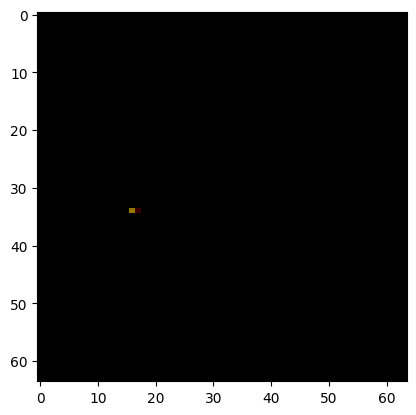

In [53]:
# Load up a cheese/no-cheese maze pair 
from experiments.patch_utils import *

seed = 0
venv = get_cheese_venv_pair(seed=seed)
obs = venv.reset()
obs = np.array(obs, dtype=np.float32)

# Show the diff of the RGB renders
print("The difference between the two images is:")
plt.imshow(rearrange(obs[0]-obs[1], 'c h w -> h w c'))

In [55]:
%reload_ext autoreload
%autoreload 2

# %%
# Imports
from typing import List, Tuple, Dict, Union, Optional, Callable

import numpy as np
import pandas as pd
import torch as t
import plotly.express as px
import plotly as py
import plotly.graph_objects as go
from tqdm import tqdm
from einops import rearrange
from IPython.display import Video, display, clear_output
from ipywidgets import Text, interact, IntSlider, fixed, FloatSlider, Dropdown
import itertools
from moviepy.video.io.ImageSequenceClip import ImageSequenceClip
import matplotlib.pyplot as plt

@interact 
def custom_values(seed=IntSlider(min=0, max=100, step=1, value=0)):
    global v_env # TODO this seems to not play nicely if you change original seed? Other mazes are negligibly affected
    v_env = get_custom_venvs(seed=seed)

obs = v_env.reset()
obs = np.array(obs, dtype=np.float32)



interactive(children=(IntSlider(value=0, description='seed'), Output()), _dom_classes=('widget-interact',))

In [ ]:
# Visualize the activations for this pair
make_interactive_plotter(plot_activations, lambda label: activation_diff(label, obs))

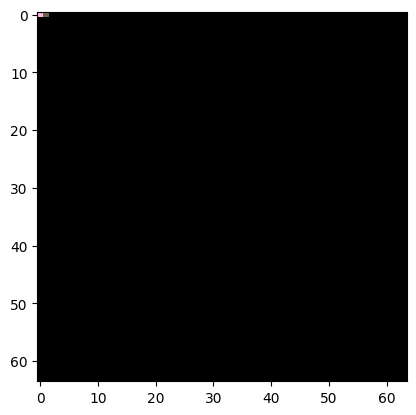

In [117]:
cheese_pixels = obs[0][(obs[0]-obs[1]) != 0] # Get the nonzero pixels
cheese_pixels = [(cheese_pixels[i], cheese_pixels[i+1], cheese_pixels[i+2]) for i in range(0, len(cheese_pixels), 3)] # Split into (R,G,B) tuples

def show_cheese_at(col: int, row: int):
    """ Make an all-black image with cheese at the given location. """
    obs = np.zeros((3,64,64), dtype=np.float32)
    obs[:, row, col] = cheese_pixels[0]
    obs[:, row, col+1] = cheese_pixels[1]
    return obs

plt.imshow(rearrange(show_cheese_at(0,0), 'c h w -> h w c'))

In [6]:
%reload_ext autoreload
%autoreload 2

# %%
# Imports
from typing import List, Tuple, Dict, Union, Optional, Callable

import numpy as np
import pandas as pd
import torch as t
import plotly.express as px
import plotly as py
import plotly.graph_objects as go
from tqdm import tqdm
from einops import rearrange
from IPython.display import Video, display, clear_output
from ipywidgets import Text, interact, IntSlider, fixed, FloatSlider, Dropdown
import itertools
from moviepy.video.io.ImageSequenceClip import ImageSequenceClip
import matplotlib.pyplot as plt
from procgen_tools import maze

def get_custom_venv_pair(seed: int, num_envs=2):
    """ Allow the user to edit num_envs levels from a seed. Return a venv containing both environments. """
    venv = maze.create_venv(num=num_envs, start_level=seed, num_levels=1)
    return venv, maze._vbox_hr(maze.venv_editor(venv, check_on_dist=False))

@interact 
def custom_values(seed=IntSlider(min=0, max=100, step=1, value=1)):
    global v_env # TODO this seems to not play nicely if you change original seed? Other mazes are negligibly affected
    v_env, editor = get_custom_venv_pair(seed=seed)
    

interactive(children=(IntSlider(value=0, description='seed'), Output()), _dom_classes=('widget-interact',))

In [56]:
obs = v_env.reset()
obs = np.array(obs, dtype=np.float32)

for l in labels:
    diff = t.from_numpy (activation_diff(l, obs))
    print (t.norm (diff)/(diff.numel()))


tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(3.3083e-08)
tensor(2.3474e-08)
tensor(8.3470e-08)
tensor(0.)


# Visualizing actual observation activations

In [119]:
venv = create_venv(num=1, start_level=0, num_levels=1)

def activ_gen_cheese(label: str):
    """ Generate an observation with cheese at the given location. """
    cheese_obs = venv.reset()
    cheese_obs = np.array(cheese_obs, dtype=np.float32)
    return get_activations(label, cheese_obs)[0,:,::-1,:] # Take the first and only batch element, and flip the image vertically so that the top is at the top

# Show a maze editor side-by-side with the interactive plotter
editor = maze.venv_editor(venv, check_on_dist=False)
display(HBox([editor.children[0], make_interactive_plotter(plot_activations, activ_gen_cheese)]))
""" This throws the error
The 'children' trait of a HBox instance contains an Instance of a TypedTuple which expected a Widget, not the NoneType None. """
# This is because the editor is not a widget, but a VBox

FigureWidget({
    'data': [], 'layout': {'template': '...'}
})

interactive(children=(Dropdown(description='label', options=('embedder.block1.conv_in0', 'embedder.block1.conv…

TraitError: The 'children' trait of a HBox instance contains an Instance of a TypedTuple which expected a Widget, not the NoneType None.